# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [1]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from time import time
from sklearn.inspection import permutation_importance
from scipy import stats
import math
import datashader as ds
from datashader.mpl_ext import dsshow
from eli5.sklearn import PermutationImportance

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import multiprocessing

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
def using_datashader(ax, x, y, normalisation):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(df,ds.Point("x", "y"),ds.count(), vmin=0.1, vmax=100,norm=normalisation,aspect="auto",ax=ax)
    plt.colorbar(dsartist, ax=ax)
    
def run_model_with_cv(model,model_name, metrics, cv, X_train, Y_train, regex_name, regex_pattern):
    print("Running {} model, variables include {}".format(model_name,  regex_name))

    # Filter columns using the regex pattern in function input
    X_train = X_train[X_train.columns.drop(list(X_train.filter(regex=regex_pattern)))].copy()
    
    # Get list of all features
    feature_list = list(X_train.columns)
        
    # Perform cross validation, time how long it takes
    start = time()
    model_output = cross_validate(model, X_train, Y_train, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
    end = time()
    
    #  Create a dataframe containng scores for each performance metric
    df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
         'r2': round(abs(model_output['test_r2'].mean()),2), 'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                     index =["{}_{}".format(model_name, regex_name)])
    
    # Get the estimators 
    estimators = model_output['estimator']
    
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    return [estimators, df, feature_list]    

### Read in formatted data

In [2]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Keep only sensors with relatively complete data

In [3]:
# ### Filter to include just sensors which we know have quite complete data 
# data = data[data['sensor_id'].isin([2,6,9,10,14,18])]
# data.reset_index(inplace=True, drop = True)

In [4]:
# data = data.drop(['Pressure', 'Humidity'],axis=1) # seem obviously irrelevant
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

### Add a random variable (to compare performance of other variables against)

In [5]:
data['random'] = np.random.random(size=len(data))

In [18]:
# plt.scatter(data['Cos_time'],data['Sin_time'])#.set_aspect('equal')

## Prepare data for modelling 
### Split into predictor/predictand variables

In [6]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Split into training and test data

In [20]:
# # Split data into training and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.75, random_state=123)

In [7]:
data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num']]
# data_time_columns_test = X_test[['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num']]
# X_train = X_train.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)
Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','year', 'month','day', 'datetime', 'month_num'],axis=1)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [8]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 64)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',XGBRegressor(random_state=1, n_jobs = 200)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (n_estimators = 500, random_state = 1, n_jobs = 32)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [9]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [12]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$'}
#                      'nosubtyes':'buildings_|furniture_|landmarks_|sensor_id'}
#                      'time_and_weather':'buildings|furniture|landmarks|h_|lights|avg_n_floors|betweenness',
#                       'just_location_features':'buildings$|furniture$|landmarks$|school_holiday|public_holiday|Temp|Humidity|Pressure|Rain|WindSpeed|Sin|Cos'}

### Loop through each combination of the models, and the variables to include in the modelling

In [21]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

models_dict = {"linear_regressor": lr_model_pipeline, "xgb_regressor":xgb_model_pipeline, 
               "rf_regressor":rf_model_pipeline, "et_regressor":et_model_pipeline}
for model_name,model in models_dict.items():
    for regex_name, regex in column_regex_dict.items():
        # Run the model: return the estimators and a dataframe containing evaluation metrics
        estimators, error_metrics_df, feature_list = run_model_with_cv(
            model, model_name, error_metrics, cv_parameters, Xfull, Yfull, regex_name, regex) 
        # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
        error_metric_scores = error_metric_scores.append(error_metrics_df)
        
        # Create dataframe of feature importances (no feature importances for linear regression)
        if model_name != 'linear_regressor':
            feature_importances = pd.DataFrame(index =[feature_list])
            for idx,estimator in enumerate(estimators):
                    feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
            feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

In [22]:
error_metric_scores

,mae,r2,rmse
linear_regressor_withsubtypes,224.28,0.47,316.58
xgb_regressor_withsubtypes,83.21,0.87,156.74
rf_regressor_withsubtypes,72.61,0.88,147.56


### Feature importances?

In [17]:
# feature_importance_scores["xgboost_withsubtypes"].sort_values('Estimator0', ascending = False)[0:10]

## Choose the best model 

Random Forest was the best performing model

## Fit the final model
For this, we use all of the training data

In [10]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],
                                    ['rf_regressor',RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 64)]])
rf_model_pipeline.fit(Xfull, Yfull)

Pipeline(steps=[('scaler', StandardScaler()),
                ['rf_regressor',
                 RandomForestRegressor(n_estimators=500, n_jobs=64,
                                       random_state=1)]])

### Use this model to make predictions

In [ ]:
# rf_predictions = rf_model_pipeline.predict(X_test)

### Find the absoloute error in each prediction

In [49]:
# final_model_predictions_df = pd.DataFrame({'Predictions' :rf_predictions, 'Original':Y_test,
#                           'abs_errors': abs(rf_predictions - Y_test),'Hour':data_time_columns_test['time']})

In [29]:
# # Calculate the absolute errors
# abs_errors = abs(rf_predictions - Y_test)
# # Mean absolute percentage errors
# mape = mean_absolute_percentage_error(Y_test, rf_predictions)
# # Mean absolute error
# mae = round(np.mean(abs_errors), 2)
# # Calculate r2 value (well, just_rvalue, its squared in the print statement)
# m, b, r_value, p_value, std_err = stats.linregress(rf_predictions, Y_test)
# # RMSE
# MSE = np.square(np.subtract(rf_predictions,Y_test)).mean() 
# RMSE = math.sqrt(MSE)

# # Add to Dataframe
# accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['RandomForest_allhours'])
# accuracy_results_rf

### Find the error for each hour of the day

In [11]:
# all_hours_accuracy = pd.DataFrame()

# for hour in list(range(0,24)):
#     this_hour = final_model_predictions_df[final_model_predictions_df['Hour']==hour]

#     # Mean absolute percentage errors
#     mape = mean_absolute_percentage_error(this_hour['Original'], this_hour['Predictions'])
#     # Mean absolute error
#     mae = round(np.mean(this_hour['abs_errors']), 2)
#     # Calculate r2 value (well, just_rvalue, its squared in the print statement)
#     m, b, r_value, p_value, std_err = stats.linregress(this_hour['Predictions'], this_hour['Original'])
#     # RMSE
#     MSE = np.square(np.subtract(this_hour['Predictions'], this_hour['Original'])).mean() 
#     RMSE = math.sqrt(MSE)
    
#     # Add to Dataframe
#     accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =[hour])

#     all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)
        
# all_hours_accuracy = all_hours_accuracy.append(accuracy_results_rf)

In [12]:
# all_hours_accuracy

In [ ]:
### Check error variation at time of dau 

In [ ]:
plt.bar(list(range(0,24)), all_hours_accuracy['MAE'][:-1])

### Find Gini impurity feature importances

In [19]:
# Get numerical feature importances
rf_importances = list(rf_model_pipeline['rf_regressor'].feature_importances_)
rf_feature_importances = pd.DataFrame({'feature': Xfull.columns,'importance':rf_importances})      
rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = True)
# rf_feature_importances = rf_feature_importances[0:10]

rf_feature_importances_overrandom = rf_feature_importances[rf_feature_importances['importance']>rf_feature_importances.query("feature=='random'")["importance"].values[0]]

### Find the permutation importance

In [25]:
# instantiate permuter object
permuter = PermutationImportance(rf_model_pipeline['rf_regressor'], scoring='neg_mean_absolute_error', cv='prefit', n_iter=2, random_state=42)
permuter.fit(Xfull.values, Yfull)
eli5_permutation_fi = pd.DataFrame({'Feature_name':Xfull.columns,
              'Feature_importance':permuter.feature_importances_,
              'Feature_importance_std': permuter.feature_importances_std_}).sort_values('Feature_importance', ascending = True)

eli5_permutation_fi_overrandom = eli5_permutation_fi[eli5_permutation_fi['Feature_importance']>eli5_permutation_fi.query("Feature_name=='random'")["Feature_importance"].values[0]]

### Plot and compare feature importances

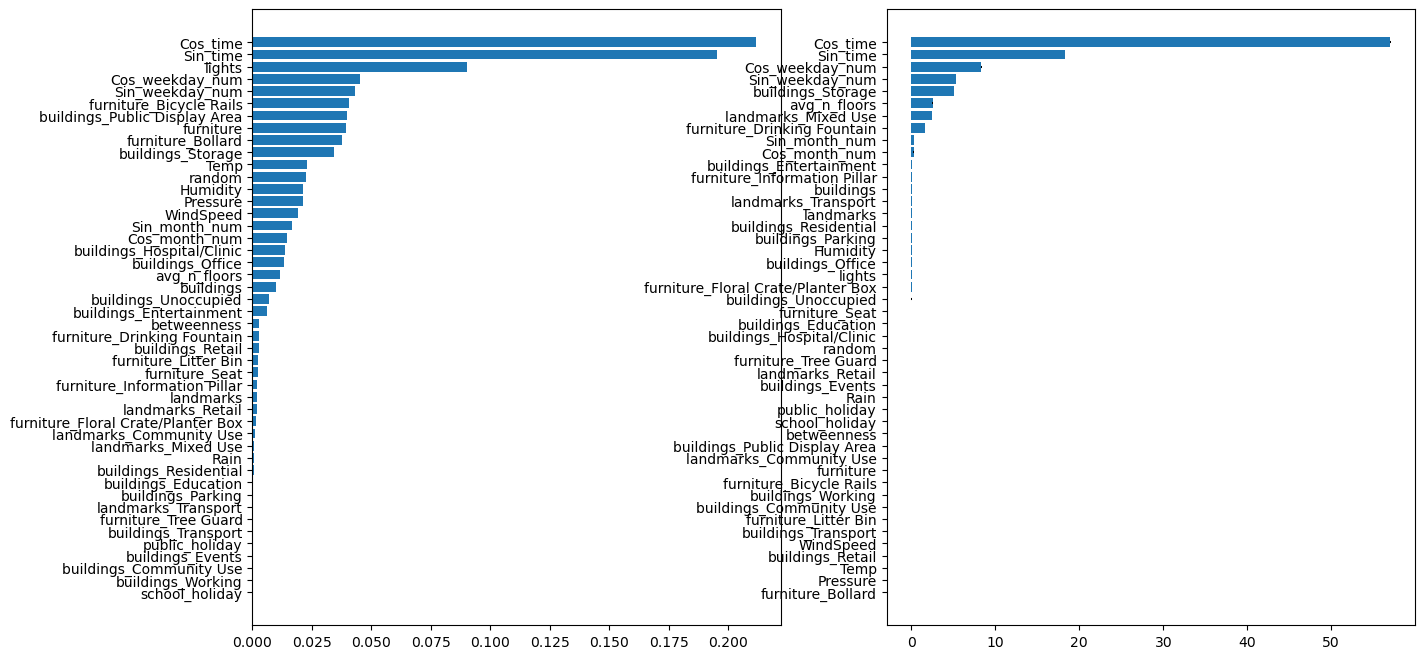

In [26]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,8))
axs[0].barh(range(len(rf_feature_importances['importance'])), rf_feature_importances["importance"])
axs[0].set_yticks(range(len(rf_feature_importances["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances["feature"]))

axs[1].barh(range(len(eli5_permutation_fi['Feature_importance'])),
         eli5_permutation_fi['Feature_importance'],
         xerr=eli5_permutation_fi['Feature_importance_std'])
axs[1].set_yticks(range(len(eli5_permutation_fi['Feature_importance'])))
_ = axs[1].set_yticklabels(eli5_permutation_fi['Feature_name'])   

### Plot just the features that scored more highly than 'random'

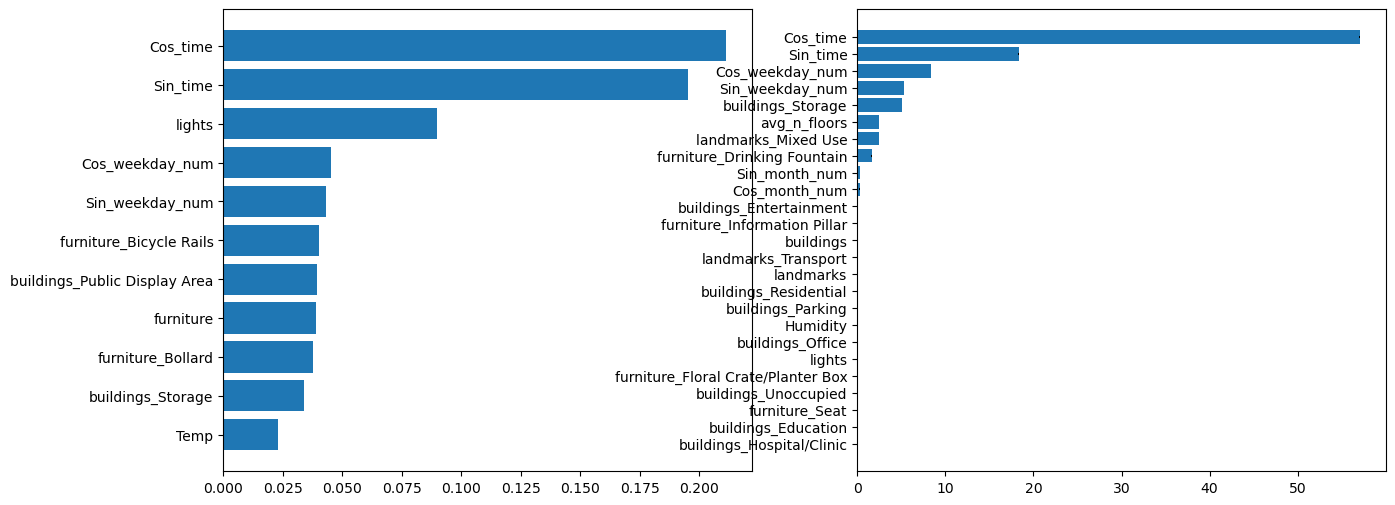

In [27]:
fig, axs = plt.subplots(ncols = 2, figsize=(15,6))
axs[0].barh(range(len(rf_feature_importances_overrandom['importance'])), rf_feature_importances_overrandom["importance"])
axs[0].set_yticks(range(len(rf_feature_importances_overrandom["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances_overrandom["feature"]))

axs[1].barh(range(len(eli5_permutation_fi_overrandom['Feature_importance'])),
         eli5_permutation_fi_overrandom['Feature_importance'],
         xerr=eli5_permutation_fi_overrandom['Feature_importance_std'])
axs[1].set_yticks(range(len(eli5_permutation_fi_overrandom['Feature_importance'])))
_ = axs[1].set_yticklabels(eli5_permutation_fi_overrandom['Feature_name'])   

### Plots!?

NameError: name 'Y_test' is not defined

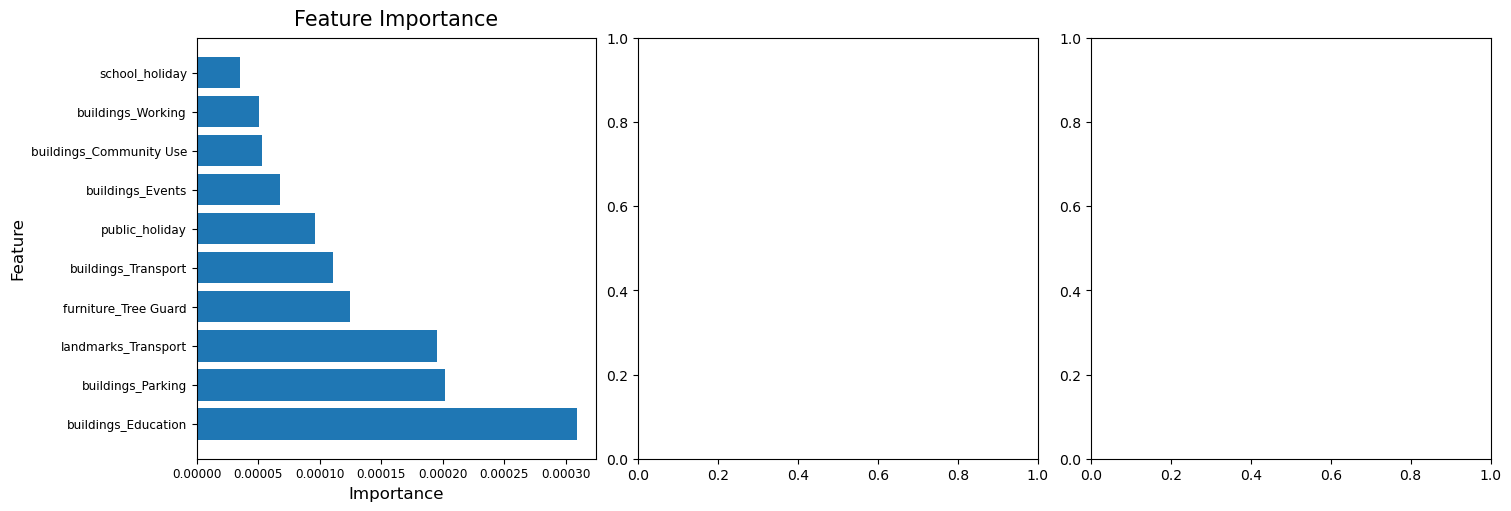

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[1],Y_test, rf_predictions, 'linear')
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], Y_test, rf_predictions, 'log')
# axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_ylabel("Predicted Values", size=10)
axs[2].set_xlabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()